In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.interpolate
from classy import Class

import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['mathtext.fontset'], plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 15})

## Best fitting with CLASS and scipy.optimize

In [2]:
home = os.getcwd()
print('Current working directory:', home)

Current working directory: /mnt/c/Users/darby/OneDrive/Desktop/cosmo_dep_feedback


In [3]:
# Fixed cosmological parameters
Ω_b = 0.049
h = 0.6711
n_s = 0.9624
ω = -1
M_ν = 0.0 #eV
Ω_k = 0

In [4]:
## Load in IllustrisTNG simulation parameters
lhc_TNG = np.loadtxt(home+'/latin_hypercube_params_IllustrisTNG.txt')

# Ω_m, σ_8, A_SN1, A_SN2, A_AGN1, A_AGN2
Ω_m, σ_8, A1, A2, A3, A4 = lhc_TNG[:,0], lhc_TNG[:,1], lhc_TNG[:,2], lhc_TNG[:,2], lhc_TNG[:,4], lhc_TNG[:,5]

In [5]:
## Load in data 
# redshift, z = 0.00
k = np.load(home+'/Pk/IllustrisTNG_k_m_z=0.00.npy')
Pk = np.load(home+'/Pk/IllustrisTNG_Pk_m_z=0.00.npy')
Pk0 = Pk[0]

In [6]:
# Paco said k values less than 30 should be good so I will cut out those values.
## Jia goes up to k_max=10, so I will use that here.
index = np.where(k>10)[0]
ks = k[0:index[0]]
Pks0 = Pk0[0:index[0]]

ks.shape, Pks0.shape

((39,), (39,))

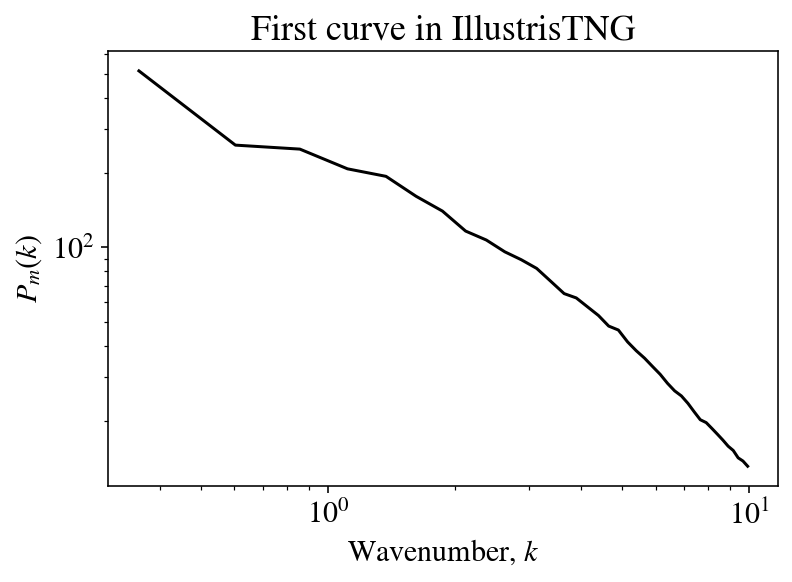

In [7]:
plt.figure()
plt.title('First curve in IllustrisTNG')
plt.loglog(ks, Pks0, 'k')
plt.xlabel('Wavenumber, $k$')
plt.ylabel('$P_m(k)$')
plt.show()

In [34]:
# Interpolating k values
# interp = scipy.interpolate.interp1d(k, Pk0)

# Curve fit model using CLASS
def class_model(x_data, eta, c):
    model = Class()
    model.set({'output':'mPk',
               'non_linear':'hmcode',
#                'feedback model': 'owls_agn',
               'h': h,
               'n_s': n_s,
               'Omega_b': Ω_b,
               'Omega_k': Ω_k,
               'eta_0': eta,
               'c_min': c,
               'P_k_max_h/Mpc': 100,  # This value must agree with max value in logspace for k_model
               'lensing':'no',
               'z_pk':0 
              })
    model.compute()
    
    k_model = np.linspace(min(x_data), max(x_data), len(x_data))
    
    Pk_model = [] 
#     h = model.h() 
    for k in k_model:
        Pk = model.pk(k*h, 0)*h**3
        Pk_model.append(Pk) 
    Pk_model = np.array(Pk_model)
    
    return Pk_model

In [69]:
guesses = np.array([0.76, 2.32]) # 'owls_agn' params
opt, cov = scipy.optimize.curve_fit(class_model, ks, Pks0, guesses) 
opt

array([   6.41119608, 1196.80609983])

In [101]:
guesses2 = np.array([0.001, 1]) # changing OOM
opt2, cov2 = scipy.optimize.curve_fit(class_model, ks, Pks0, guesses) 
opt2

array([   6.41119608, 1196.80609983])

NOTE: Changing the guesses by many OOM did not help scipy.optimize come out of it's local minimum. Run MCMC to see if that helps.

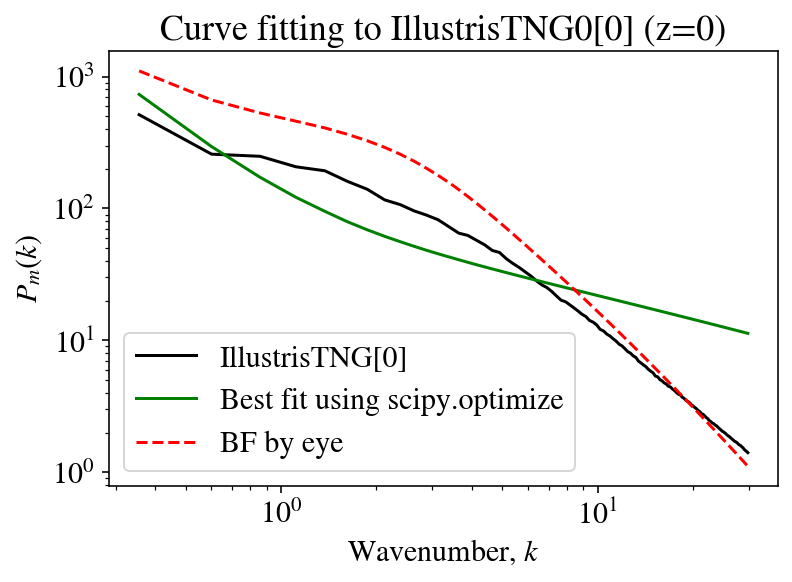

In [100]:
plt.figure()
plt.loglog(ks, Pks0, 'k', label='IllustrisTNG[0]')
plt.loglog(ks, class_model(ks, *opt), 'g', label='Best fit using scipy.optimize')
plt.loglog(ks, class_model(ks, 0.005, 3), 'r--', label='BF by eye')
# plt.loglog(ks, class_model(ks, 0.3, 3), 'b:', label='BF by eye II')
plt.legend()
plt.title('Curve fitting to IllustrisTNG0[0] (z=0)')
plt.xlabel('Wavenumber, $k$')
plt.ylabel('$P_m(k)$')
plt.show()

Because I can find a better fit by curve fitting by eye, I am assuming that I am once again getting stuck in some local minimum. So I will need to use MCMC or something similar to find the global minimum.

## Interpolation scratch work

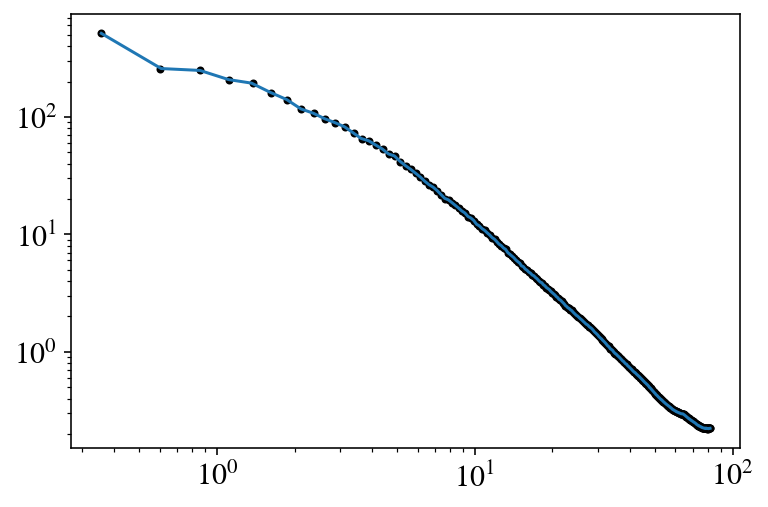

In [121]:
plt.figure()
plt.loglog(k_cut, Pk0_cut, 'k.')

xnew = np.linspace(min(k_cut), max(k_cut), len(k_cut))
f_lin = scipy.interpolate.interp1d(k_cut, Pk0_cut, fill_value='extrapolate', kind='linear')
plt.loglog(xnew, f_lin(xnew))

# plt.loglog(k_cut, Pk0_cut)
plt.show()

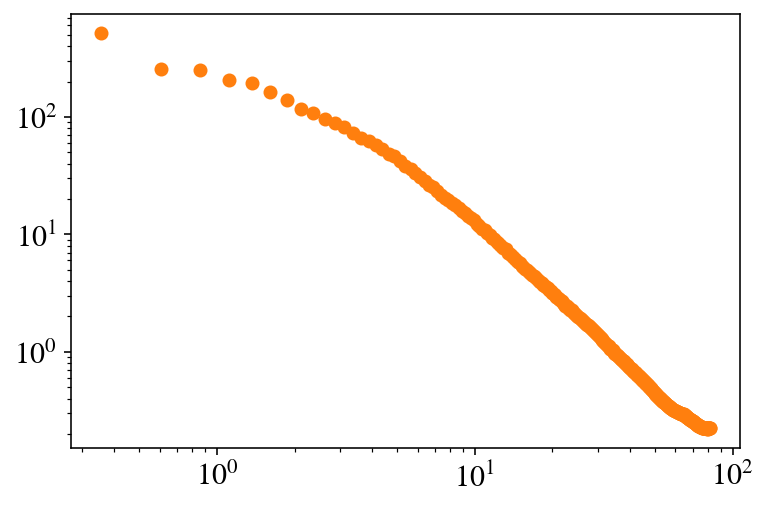

In [129]:
x = k_cut
y = Pk0_cut
# My x and y are the Pk and k data from IllustrisTNG
interp = scipy.interpolate.interp1d(x, y, fill_value="extrapolate") # Interpolator

xnew = np.linspace(min(x), max(x), len(k_cut))
ynew = interp(xnew)   # use interpolation function returned by `interp1d`
plt.loglog(x, y, '.') #
plt.loglog(xnew, ynew, 'o')
plt.show()
# orange is model --> CLASS Pk and k

## Trying MCMC with CLASS

In [8]:
import emcee
import corner

In [9]:
# Fixed cosmological parameters
Ω_b = 0.049
h = 0.6711
n_s = 0.9624
ω = -1
M_ν = 0.0 #eV
Ω_k = 0

In [10]:
Pks0_err = 0.10*Pks0 # fake 10% error for now

In [13]:
# Log-likelihood function:
def log_likelihood(theta, x, y, yerr):
    eta, c = theta
    model = Class()
    model.set({'output':'mPk',
               'non_linear':'hmcode',
#                'feedback model': 'owls_agn',
               'h': h,
               'n_s': n_s,
               'Omega_b': Ω_b,
               'Omega_k': Ω_k,
               'eta_0': eta,
               'c_min': c,
               'P_k_max_h/Mpc': 100,  # This value must agree with max value in logspace for k_model
               'lensing':'no',
               'z_pk':0 
              })
    model.compute()
    
    k_model = np.linspace(min(x), max(x), len(x))
    Pk_model = [] 
#     h = model.h() 
    for k in k_model:
        Pk = model.pk(k*h, 0)*h**3
        Pk_model.append(Pk) 
    Pk_model = np.array(Pk_model)
    
    sigma2 = yerr**2
    return -0.5 * np.sum((y - Pk_model)**2 / sigma2 + np.log(sigma2))

In [14]:
nll = lambda *args: -log_likelihood(*args)
# maximizing the likelihood is the same as minimizing the negative of the liklihood
initial = np.array([0.76, 2.32]) # owls_agn params
soln = scipy.optimize.minimize(nll, initial, args=(ks, Pks0, Pks0_err))
eta_ml, c_ml = soln.x # maximum likelihood values
print('Maximum likelihood values:', soln.x)

Maximum likelihood values: [ 1.85135148 17.06439442]


Note the difference in these values versus those provided by scipy.optimize.

In [15]:
# Log priors
def log_prior(theta): # sets up priors on theta
    eta, c = theta
    if -20 < eta < 20 and -10 < c < 50:
        return 0.0
    return -np.inf 

In [16]:
# Log probability
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta) 
    if not np.isfinite(lp): 
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [24]:
pos = soln.x + 1e-2 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape
# pos
sampler = emcee.EnsembleSampler(nwalkers, 
                                ndim,
                                log_probability,
                                args=(ks, Pks0, Pks0_err))

sampler.run_mcmc(pos, 50, progress=True)

100%|███████████████████████████| 50/50 [1:14:15<00:00, 89.11s/it]


State([[ 1.89657067 17.8870741 ]
 [ 1.8532774  16.67316445]
 [ 2.10020169 22.46419306]
 [ 1.98536238 20.21629522]
 [ 1.74354722 14.78723253]
 [ 1.84120869 15.95403877]
 [ 1.68472732 14.19376011]
 [ 1.6941525  14.33733101]
 [ 1.82411619 15.4831575 ]
 [ 1.99182875 20.15913073]
 [ 1.77623172 15.66248967]
 [ 1.98950183 18.56566399]
 [ 1.64425306 13.4757025 ]
 [ 1.82465211 17.0240388 ]
 [ 1.86643343 16.75092965]
 [ 2.03801499 20.86774998]
 [ 1.81667333 15.87042638]
 [ 1.96033277 19.56096908]
 [ 1.76547338 15.37523296]
 [ 1.90895115 17.52494463]
 [ 1.69730701 14.74764108]
 [ 1.75435745 15.86092153]
 [ 1.84363971 17.58663173]
 [ 1.93581579 19.4618107 ]
 [ 1.8109844  16.56866803]
 [ 1.84241455 16.91665475]
 [ 2.04281735 21.24668977]
 [ 1.8326845  17.00538759]
 [ 1.8900565  18.4992543 ]
 [ 2.16145367 22.9915633 ]
 [ 2.11011711 22.35274882]
 [ 1.90380486 18.28256991]], log_prob=[-164.60389549 -164.7563013  -167.13018902 -165.64965261 -165.45635198
 -165.72170034 -165.99900096 -165.83358915 -166.

In [28]:
samples = sampler.get_chain()
np.save('MCMC_runs/50_chain_CAMELS_MCMC_test_run.npy', samples)

# tau = sampler.get_autocorr_time()
# print('Integrated autocorrelation time:', tau)

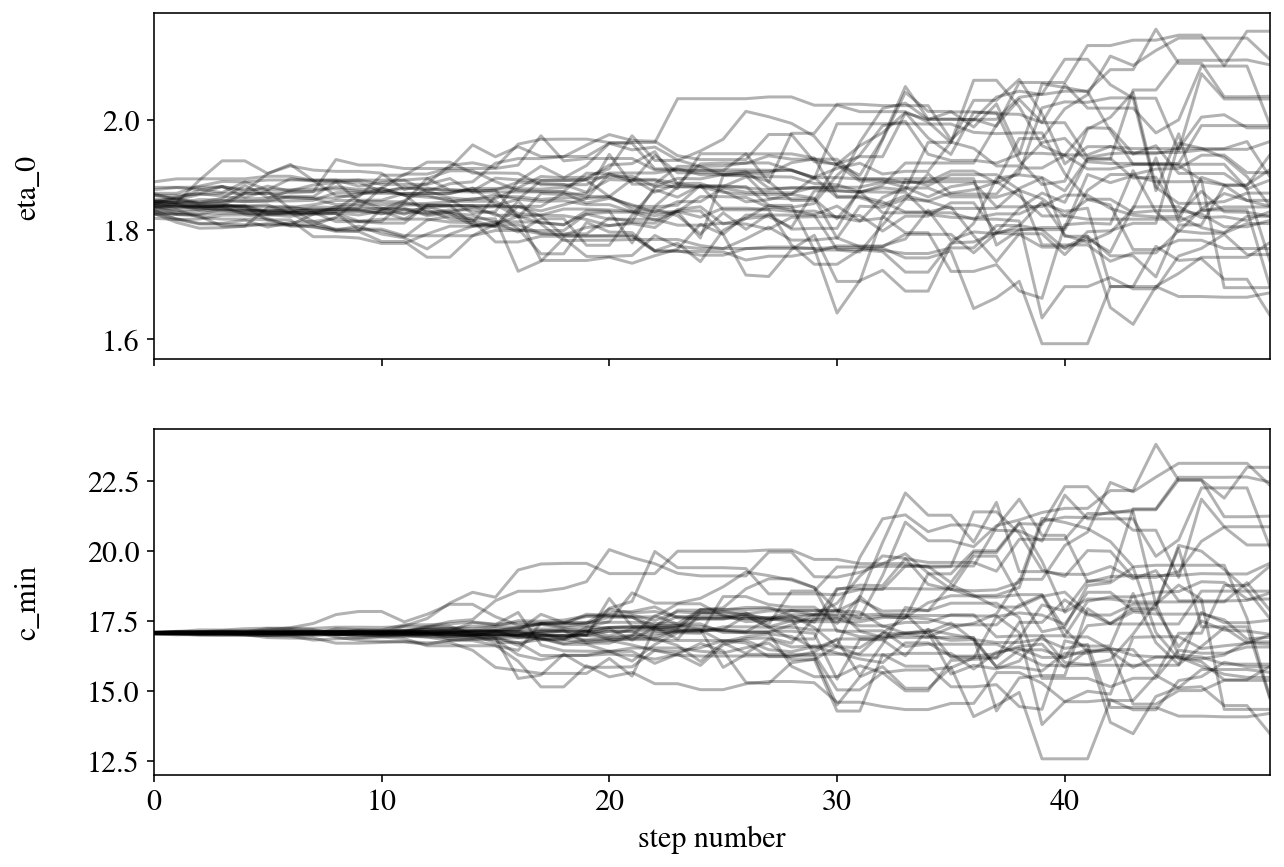

In [29]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
labels = ['eta_0', 'c_min']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples)-1)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel('step number');

(512, 2)


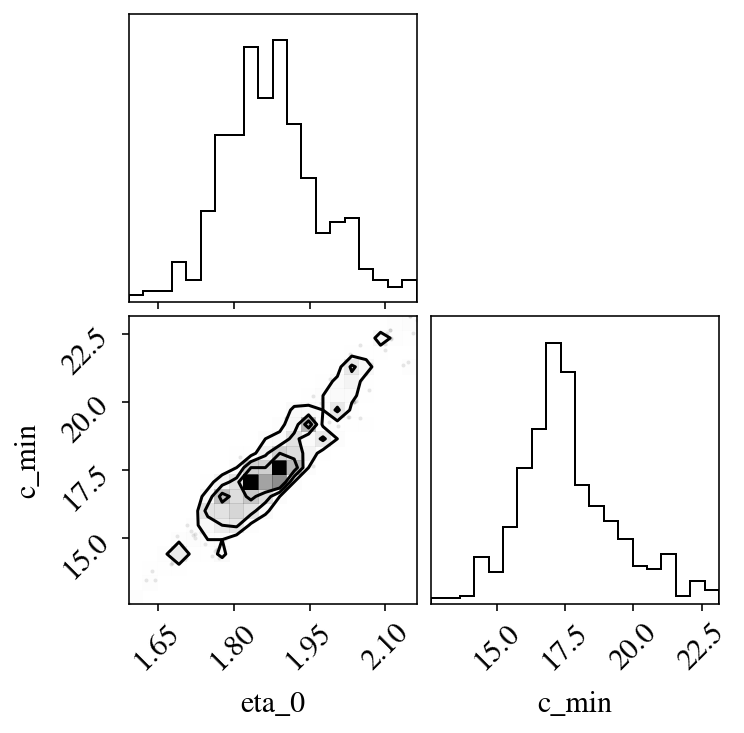

In [30]:
flat_samples = sampler.get_chain(discard=18, thin=2, flat=True)
print(flat_samples.shape)

fig = corner.corner(flat_samples, labels=labels, truths=initial);

In [32]:
from IPython.display import display, Math

labels = ['eta_0', 'c_{min}']

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<Figure size 432x288 with 0 Axes>

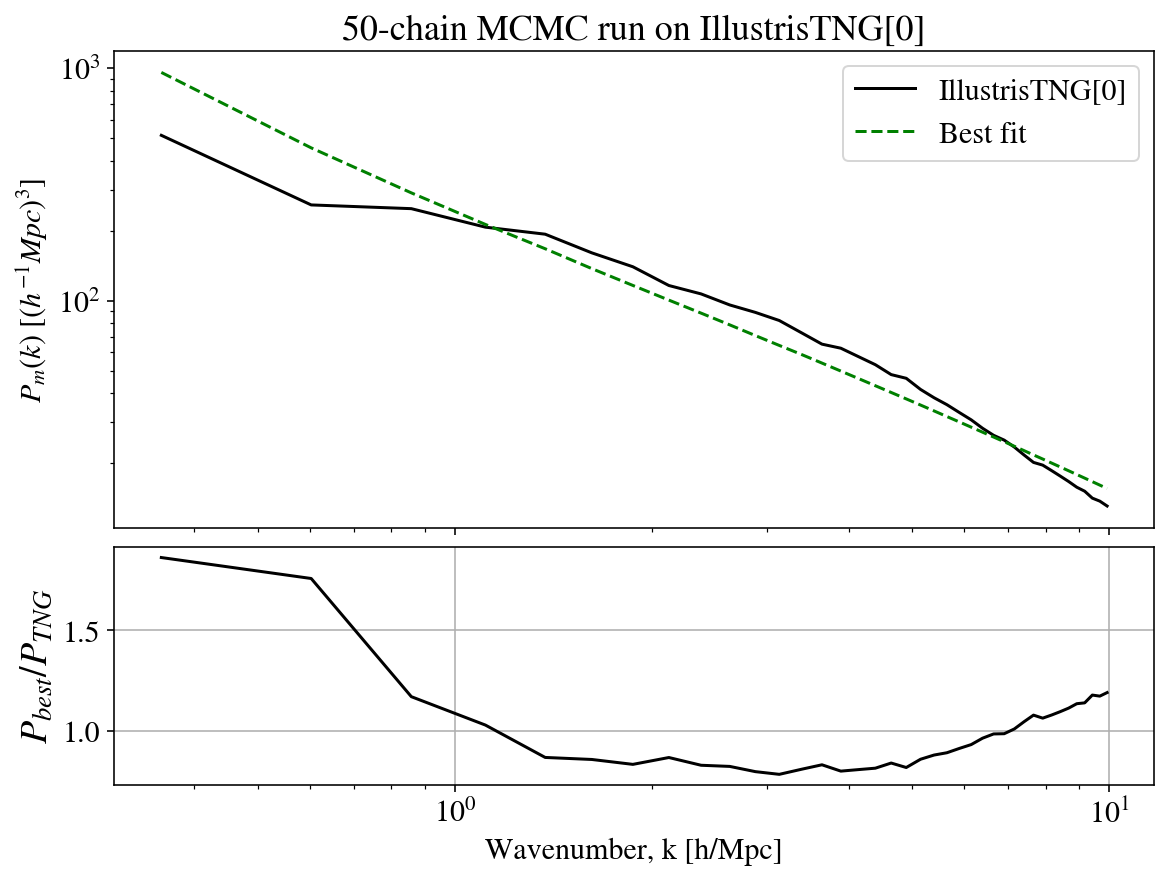

In [81]:
plt.figure()
fig, (ax0, ax1) = plt.subplots(ncols=1, nrows=2, 
                               figsize=(8,6), 
                               constrained_layout=True, 
                               sharex=True, 
                               gridspec_kw={'height_ratios':[3, 1.5]})

ax0.set_title('50-chain MCMC run on IllustrisTNG[0]')
ax0.loglog(ks, Pks0, 'k', label='IllustrisTNG[0]')
ax0.set_ylabel('$P_m(k)$ [($h^{-1}Mpc)^3$]')
ax0.loglog(ks, class_model(ks, 1.870, 17.335), 'g--', label='Best fit')
ax0.legend()

ax1.semilogx(ks, class_model(ks, 1.870, 17.335)/Pks0, 'k')
ax1.set_ylabel('$P_{best}/P_{TNG}$', fontsize=19)
ax1.set_xlabel('Wavenumber, k [h/Mpc]')
ax1.grid()

plt.show()